<a href="https://colab.research.google.com/github/tfjgeorge/nngeometry-examples/blob/main/Continual_learning_EWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NNGeometry applied to continual learning

The goal of this colab is to implement the Elastic Weight Consolidation (EWC) continual learning algorithm for several approximations of the Fisher Information Matrix (FIM) using NNGeometry.

This notebooks is organized as follows:
 1. Create of continual learning sequence of tasks and learning logic
 2. EWC class using NNGeometry with diagonal and KFAC approximations of the FIM
 3. Definition of the neural network
 3. Learning
 4. Results

 ## References:

 - Diagonal EWC original paper: Kirkpatrick et al. Overcoming catastrophic forgetting in neural networks. Proceedings of the national academy of sciences 2017
 - KFAC EWC paper: Ritter et al. Online structured laplace approximations for overcoming catastrophic forgetting. NeurIPS 2018

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from copy import deepcopy
from torch.nn import functional as F
from tqdm.notebook import tqdm

# 1. Continual learning

Then, we install Continuum (https://github.com/Continvvm/continuum), a library to create continual learning scenarios. We will use it to create a scenario called MNIST_Fellowship, where MNIST, FashionMNIST and kMNIST will be learned sequentially.

In [2]:
!pip install continuum

     |████████████████████████████████| 81kB 3.8MB/s 


We implement a function to train or evaluate a model on a task. This function needs the task set, the model to train, the optimizer, the list of ewc class (one per past tasks) that will be used to regularized the gradient, the importance of the regularization and a boolean flag to know if the task should be used to train or just for evaluation.

In [3]:
def process_task(task_set, model, optimizer, ewc_list, importance, train):

    task_loader = DataLoader(task_set, batch_size=64, shuffle=True, num_workers=6)

    if train:
      model.train()
    else:
      model.eval()

    epoch_loss = 0
    correct = 0

    for i_, (x_, y_, t_) in enumerate(task_loader):

      x_, y_ = torch.FloatTensor(x_).cuda(), torch.LongTensor(y_).cuda()
      if train:
        optimizer.zero_grad()
      predictions = model(x_)

      # we compute the number of good predictions
      correct += (predictions.max(dim=1)[1] == y_).data.sum().cpu().item()

      # we compute the loss without regularization
      loss = F.cross_entropy(predictions, y_)
      epoch_loss += loss.cpu().item()

      if train:
        # we apply the regularization for training
        for n, ewc in ewc_list.items():
            regule = ewc.penalty(model)
            loss += importance * regule
        loss.backward()
        optimizer.step()

    accuracy=100*correct / len(task_loader.dataset)
    loss_mean=epoch_loss / (1.0 * len(task_loader.dataset))

    return loss_mean, accuracy

We create the neural network that will be trained on the sequence of tasks. 28*28  images as input and 30 outputs.

In [4]:
class Base_Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Base_Net, self).__init__()
        self.num_classes = num_classes

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, self.num_classes, bias=False)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)

        x = self.relu(self.maxpool2(self.conv1(x)))
        x = self.relu(self.maxpool2(self.conv2(x)))
        x = x.view(-1, 320)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

We import from continuum library, the datasets and scenario necessary for the experiences.

In [5]:
# we import MNISTFellowship=[MNIST,FashionMNIST,KMNIST]
from continuum.datasets import MNISTFellowship
# ClassIncremental => new tasks = new classes
from continuum import ClassIncremental

We create a function to ennumerate tasks and manage the continual training. 

In [6]:
def continual_process(epochs, importance=1000., FIM_Representation=None, num_tasks=3, verbose=False):

    # training scenario
    scenario_tr = ClassIncremental(MNISTFellowship('./data', train=True), increment=10)

    # testing scenario
    scenario_te = ClassIncremental(MNISTFellowship('./data', train=False), increment=10)

    model = Base_Net(num_classes=30).cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=0.002, momentum=0.9)
    loss_te, acc_te, ewc = {}, {}, {}

    for ind_task in range(num_tasks):
        loss_te[ind_task] = []
        acc_te[ind_task] = []

    # enumerate scenario tasks
    for task_id, dataset_tr in enumerate(scenario_tr):
        for _ in tqdm(range(epochs)):
            # train on task
            loss, acc = process_task(dataset_tr, model, optimizer,
                         ewc, importance, train=True)
            if verbose: 
              print(f"Training Accuracy Task {task_id} : {acc} % ")
            # test on all test tasks (past, present and future)
            for sub_task_id, dataset_te in enumerate(scenario_te):
              loss, acc = process_task(dataset_te, model, optimizer,
                                               ewc, importance, train=False)
              
              if verbose: 
                print(f"Validation Accuracy Task {sub_task_id} : {acc} % ")
              acc_te[sub_task_id].append(acc)
              loss_te[sub_task_id].append(loss)
        # compute the fisher matrix to protect weights learned on this task
        if (FIM_Representation is not None) and task_id < scenario_tr.nb_tasks-1: 
            ewc[task_id] = EWC(model, dataset_tr, FIM_Representation)

    return loss_te, acc_te

# 2. EWC diag and KFAC using NNGeometry

We install NNGeometry from its github repository:

In [7]:
!pip install git+https://github.com/tfjgeorge/nngeometry.git

  Cloning https://github.com/tfjgeorge/nngeometry.git to /tmp/pip-req-build-0_22ulcp
  Running command git clone -q https://github.com/tfjgeorge/nngeometry.git /tmp/pip-req-build-0_22ulcp
  Created wheel for nngeometry: filename=nngeometry-0.2.1-cp36-none-any.whl size=21030 sha256=4e39ca25685ada275997bcade9fb5c93959a38f09c7261ff357c5013f04df74f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2hbmm6f6/wheels/0e/82/b3/42a1a59c9ab5dcb2a16c557430ef6bbdce07fe33ac46af6beb
Successfully built nngeometry


For this example, we will need to import:
 - `FIM` is a helper that specifies that the metric that we are going to use is the Fisher Information Matrix. 
 - `PVector` is the vector of all parameters $\mathbf{w} = \left\{ W_1, b_1, \cdots \right\}$. Instead of having to loop through all parameters tensors, it conveniently offers an interface to do typical operations such as addition or multiplication with a scalar.
 - `PMatKFAC` and `PMatDiag` are matrix representations of the FIM.

In short:
 - `FIM` is *what* we want to compute
 - `PMatKFAC` and `PMatDiag` is *how* we are going to represent it

In [8]:
from nngeometry.metrics import FIM
from nngeometry.object import PMatKFAC, PMatDiag, PVector

We now define our class `EWC` that will be called at the end of each task in order to store the current parameters (here `self.v0`) and compute the FIM at current parameter values (here `self.Fisher`).

**Note that even if internally the mechanics are very different, switching from diagonal EWC to KFAC EWC is as simple as passing a different argument `Representation` to `FIM`.**

In [9]:
class EWC(object):
    def __init__(self, model: nn.Module, train_set, Representation):
        self.model = model
        self.train_set = train_set
        self.Fisher, self.v0 = self.compute_fisher(self.model, Representation)

    def compute_fisher(self, model, Representation):
        fisher_set = deepcopy(self.train_set)
        fisher_loader = DataLoader(fisher_set, batch_size=50, shuffle=False, num_workers=6)
        F_diag = FIM(model=model,
                     loader=fisher_loader,
                     representation=Representation,
                     n_output=30,
                     variant='classif_logits',
                     device='cuda')

        v0 = PVector.from_model(model).clone().detach()

        return F_diag, v0

    def penalty(self, model: nn.Module):
        v = PVector.from_model(model)
        regularization_loss = self.Fisher.vTMv(v - self.v0)

        return regularization_loss

# 4. Learning

Now that we are all set, we start our continual learning sequence.

First, we do not use any regularization technique. This will serve as a benchmark.

In [10]:
importance = 10
num_tasks = 3
test_label = False
epochs = 5

loss, acc = continual_process(epochs,
                              importance=importance, 
                              FIM_Representation=None,
                              num_tasks=num_tasks)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw





Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw





Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw


Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw
Processing...
Done!


In [11]:
# Training with Diagonal representation
loss_EWC, acc_EWC = continual_process(epochs,
                                      importance=importance,
                                      FIM_Representation=PMatDiag,
                                      num_tasks=num_tasks)

In [12]:
# Training with KFAC representation
loss_EWC_KFAC, acc_EWC_KFAC = continual_process(epochs,
                                                importance=importance,
                                                FIM_Representation=PMatKFAC,
                                                num_tasks=num_tasks)

# 5. Results

In [13]:
import matplotlib.pyplot as plt

We plot here the evolution of the test loss of all training strategies. The test set evaluate the algorithm's performance on all the tasks. We can see the EWC with KFAC representation has the lowest loss on the test set and that this loss continue to decrease on the last task.

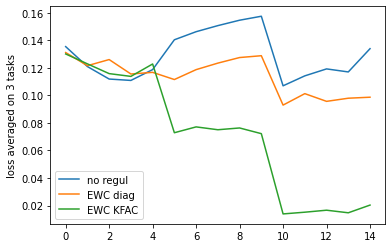

In [14]:
plt.plot(np.mean([loss[0], loss[1], loss[2]], axis=0), label='no regul')
plt.plot(np.mean([loss_EWC[0], loss_EWC[1], loss_EWC[2]], axis=0), label='EWC diag')
plt.plot(np.mean([loss_EWC_KFAC[0], loss_EWC_KFAC[1], loss_EWC_KFAC[2]], axis=0), label='EWC KFAC')
plt.legend()
plt.ylabel('loss averaged on 3 tasks')
plt.show()

We plot now, the model test accuracy with all the training strategies. As for the loss, we can see the KFAC representation perform the best. Moreover, it is the only one to improve through time.

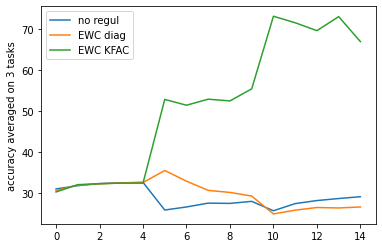

In [15]:
plt.plot(np.mean([acc[0], acc[1], acc[2]], axis=0), label='no regul')
plt.plot(np.mean([acc_EWC[0], acc_EWC[1], acc_EWC[2]], axis=0), label='EWC diag')
plt.plot(np.mean([acc_EWC_KFAC[0], acc_EWC_KFAC[1], acc_EWC_KFAC[2]], axis=0), label='EWC KFAC')
plt.legend()
plt.ylabel('accuracy averaged on 3 tasks')
plt.show()

## Testing other FIM Representations

NNgeometry library proposes other representations for the Fisher information matrix that could be used with ewc: `PMatQuasiDiag` , `PMatEKFAC`, `PMatBlockDiag` and `PMatDense`.